<a href="https://colab.research.google.com/github/liyanse/Facial-Recognition/blob/master/RemovingBackgroundImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# TODO: Upload your file and define the filename input_file
# Optional: Also upload or define the background file/url
input_file = '/content/1234.jpg'
background_url = 'https://images.unsplash.com/photo-1475139441338-693e7dbe20b6?auto=format&fit=crop&w=640&q=427'

background_file = '/content/background.jpg'
foreground_file = '/content/foreground.png'
output_file = '/content/final.jpg'

In [15]:
from urllib.request import urlretrieve
from PIL import Image
from matplotlib import pyplot as plt

# save the background 
urlretrieve(background_url, background_file)

('/content/background.jpg', <http.client.HTTPMessage at 0x7fe4cc86ca30>)

In [16]:
import cv2
import numpy as np
import torch
from torchvision import transforms

In [17]:
def load_model():
  model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
  model.eval()
  return model


In [18]:
def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

In [19]:
def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

In [20]:
deeplab_model = load_model()
foreground, bin_mask = remove_background(deeplab_model, input_file)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


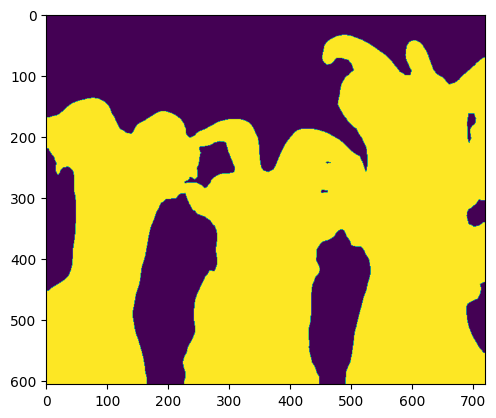

In [21]:
plt.imshow(bin_mask)

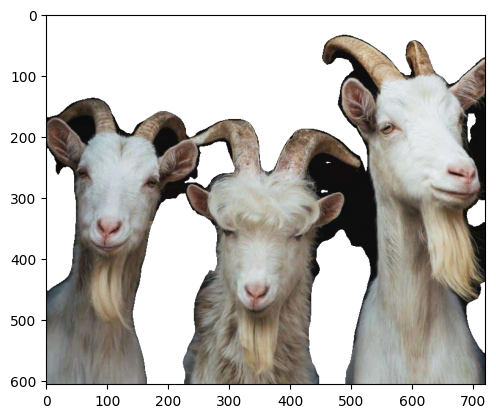

In [22]:
plt.imshow(foreground)

In [23]:
img_fg = Image.fromarray(foreground)
if foreground_file.endswith(('jpg', 'jpeg')):
  img_fg = img_fg.convert('RGB')

img_fg.save(foreground_file)

In [24]:
def custom_background(background_file, foreground):
  final_foreground = Image.fromarray(foreground)
  background = Image.open(background_file)
  x = (background.size[0]-final_foreground.size[0])/2 + 0.5
  y = (background.size[1]-final_foreground.size[1])/2 + 0.5
  box = (x, y, final_foreground.size[0] + x, final_foreground.size[1] + y)
  crop = background.crop(box)
  final_image = crop.copy()
  # put the foreground in the centre of the background
  paste_box = (0, final_image.size[1] - final_foreground.size[1], final_image.size[0], final_image.size[1])
  final_image.paste(final_foreground, paste_box, mask=final_foreground)
  return final_image

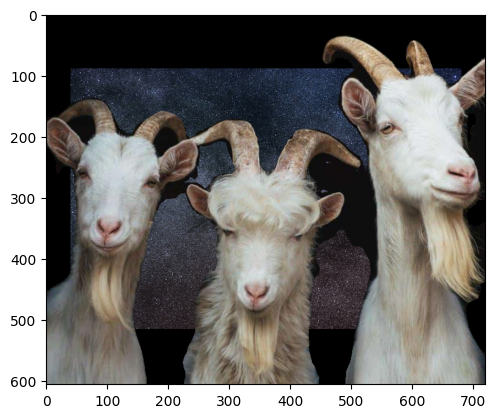

In [25]:
final_image = custom_background(background_file, foreground)
plt.imshow(final_image)

In [26]:
final_image.save(output_file)